# Finger Flexions

In [ ]:
import os 
import netCDF4 as nc 
import xarray as xa
import numpy as np
import time
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import analysis
import scipy.signal

Noise

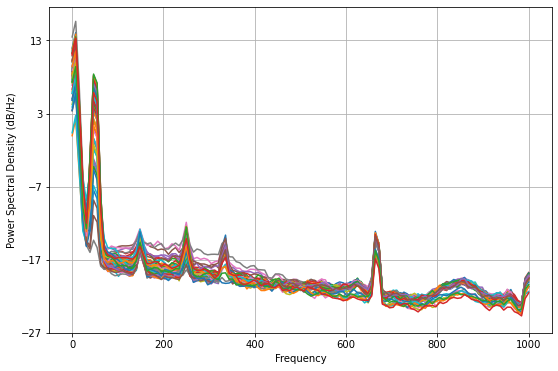

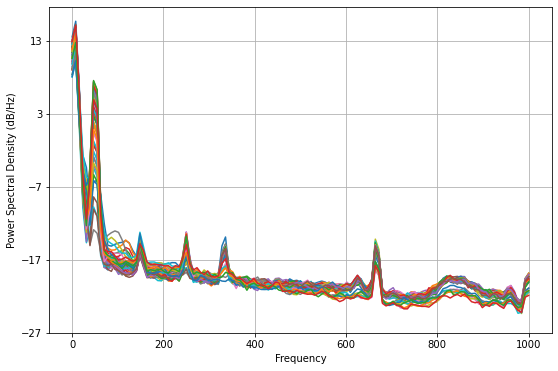

In [2]:
data_folder = Path('/Users/spencerw/Google Drive/motor_control/analysis/data/2020-04-03-spencer/')
filenames = list(data_folder.rglob('*'))
noise_files = [f for f in filenames if 'noise' in f.name]
for f in noise_files:
    ds = xa.open_dataset(f)
    fig = analysis.plot_psd(ds.emg.values)

In [3]:
data_paths = analysis.data_files(data_folder)

+ /Users/spencerw/Google Drive/motor_control/analysis/data/2020-04-03-spencer
    + 1585932649_noise_spencer.data
    + 1585932727_noise_spencer.data
    + 1585932792_index_spencer.data
    + 1585932979_middle_spencer.data
    + 1585933183_ring_spencer.data
    + 1585933364_pinky_spencer.data
    + 1585933587_index_middle_spencer.data
    + 1585933787_ring_pinky_spencer.data
    + 1585933955_middle_ring_spencer.data
    + 1585934217_index_pinky_spencer.data
    + 1585934390_index_ring_spencer.data
    + 1585934539_middle_pinky_spencer.data
    + 1585934708_index_middle_ring_pinky_spencer.data
    + 1585935459_in_order_spencer.data
    + 1585935877_alternate_index_ring_spencer.data
    + 1585936006_alternate_middle_pinky_spencer.data
    + 1585936129_thumb_spencer.data
    + 1585936295_wrist_down_spencer.data
    + 1585936429_wrist_out_spencer.data


In [4]:
fingers = ['index','middle','ring','pinky']
finger_path_lists = []
for finger in fingers:
    finger_path_lists.append([p for p in data_paths if finger in p.name])
individual_finger_paths = []
for l in finger_path_lists:
    individual_finger_paths.append(l[0])

We'll pick out each movement event from the datset and align to the "peak". 

For now we'll use the magnitude of the event, future might use something fancier. 

Dropped [-13847] samples at [2]
max:  0.09575430351172885 min:  -0.06474779648827116
shape:  (64, 252753)
processed:  0.0007792022356056221 0.02408101446377918
unprocessed:  -0.06472516531158878 0.09572083468841122
peaks:  95


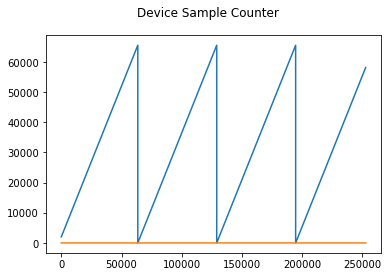

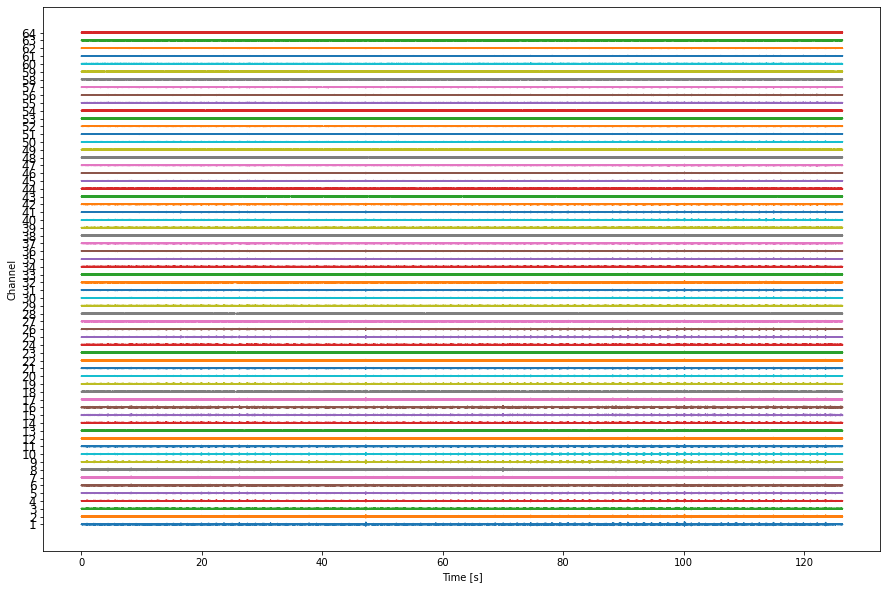

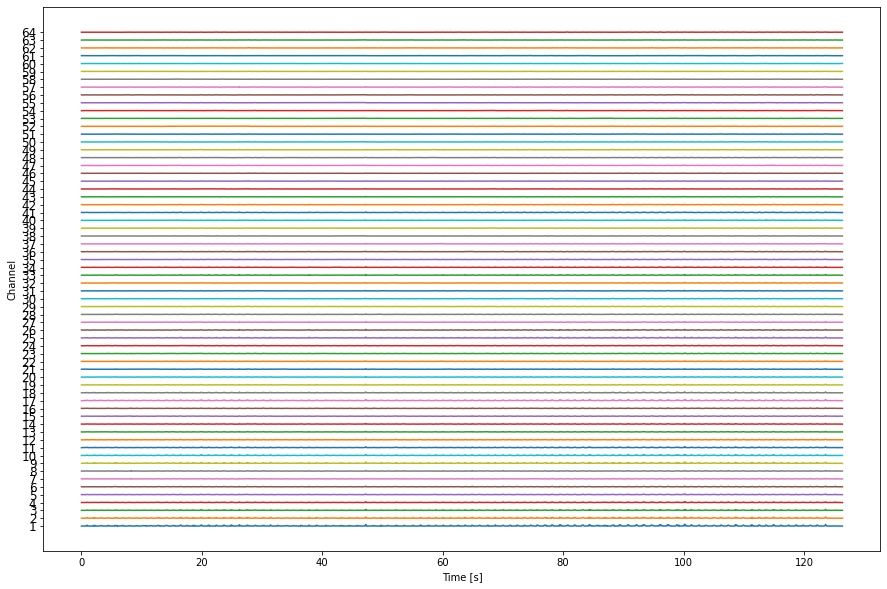

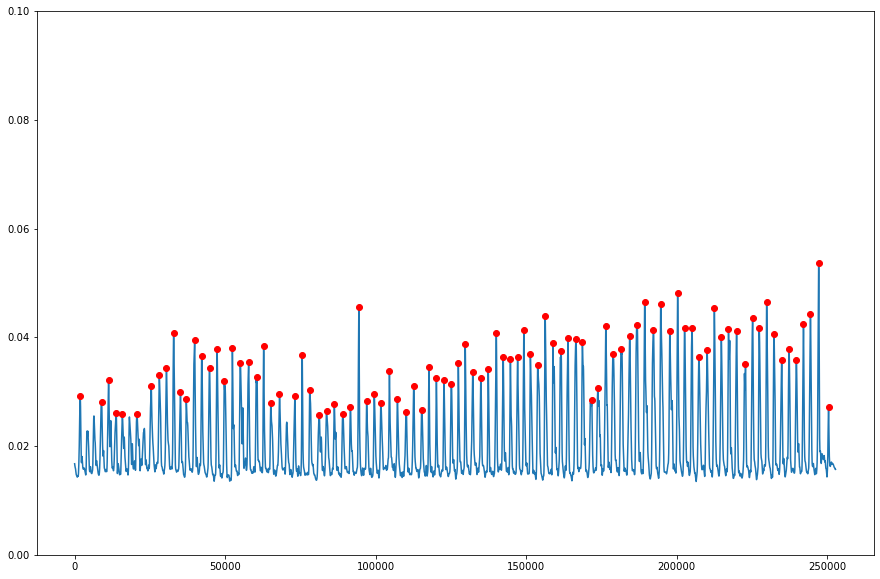

In [106]:
def load_and_preprocess_data(filepath):
    # open dataset
    dataset = xa.open_dataset(filepath)
    analysis.fill_time_array(dataset)
    # cut out start, rectify, smooth
    start_idx = 2000 # first second
#     drops = analysis.get_dropped_samples(dataset.counter.values)
    return analysis.preprocess(dataset.emg.values[:,start_idx:])

processed_emg = load_and_preprocess_data(individual_finger_paths[1])

# compare min and max
print("processed: ", np.min(processed_emg),np.max(processed_emg))
print("unprocessed: ", np.min(analysis.demean_channels(dataset.emg.values[:,start_idx:]))*0.000286, np.max(analysis.demean_channels(dataset.emg.values[:,start_idx:]))*0.000286)

# plot data pre and postprocessing
fig = analysis.plot_counter(dataset.counter.values[0,start_idx:])
fig = analysis.plot_biolectric(dataset.emg.values[-1,start_idx:start_idx+10000],offset=1000)
fig = analysis.plot_biolectric(processed_emg[-1,:10000],offset=0.1)

# find and plot event peaks 
events = analysis.blur(np.linalg.norm(processed_emg,axis=0).reshape(-1,1).T,sigma=100)
percentile = np.percentile(events,80)
width = 500
peak_indices, peak_heights = scipy.signal.find_peaks(events[0], height=(percentile,np.max(events)),distance=width*2)
peak_heights = peak_heights['peak_heights']
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.set_ylim([0,0.1])
ax.plot(events[0])
ax.plot(peak_indices,peak_heights,'ro')
print("peaks: ", len(peak_indices))

## PCA on invidual fingers

In [108]:
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

In [107]:
individual_finger_data = []
for path in individual_finger_paths:
    individual_finger_data.append(load_and_preprocess_data(path))

Dropped [-59358] samples at [2]
max:  0.09522670521615033 min:  -0.06928079478384969
shape:  (64, 273976)
Dropped [-13847] samples at [2]
max:  0.09575430351172885 min:  -0.06474779648827116
shape:  (64, 252753)
Dropped [] samples at []
max:  0.24910437885311856 min:  -0.4444020211468815
shape:  (64, 244088)
Dropped [-49494    366    384    366    384    366    384    360    384    348
    384    384] samples at [     2 168731 168734 168737 168740 168743 168746 168749 168752 168767
 168770 171872]
max:  0.13681082275915088 min:  -0.24375890891283258
shape:  (64, 243256)


In [117]:
pca_components = []
pca = PCA()
for array in individual_finger_data:
    # model takes (samples, features)
    pca.fit(array.T)
    pca_components.append(pca.components_)

(64, 64)
(64, 64)
(64, 64)
(64, 64)


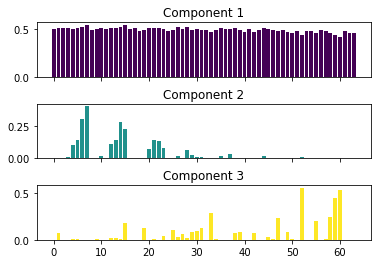

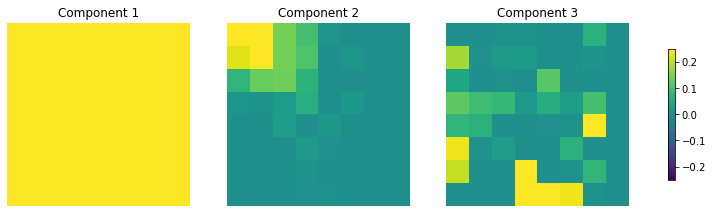

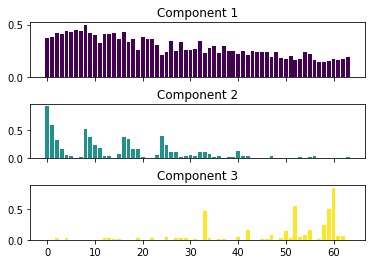

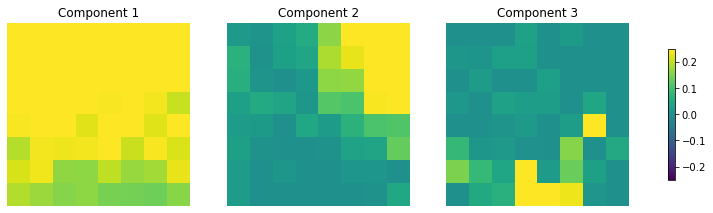

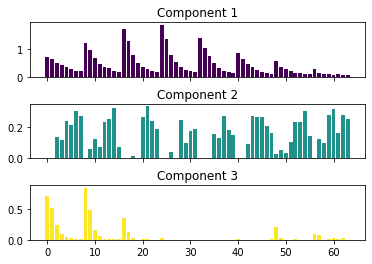

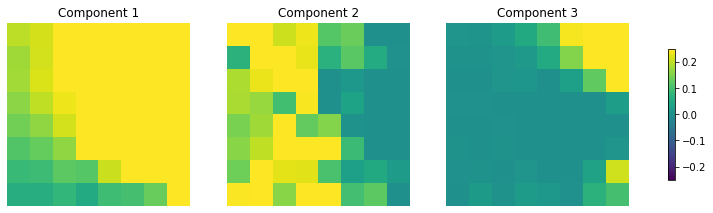

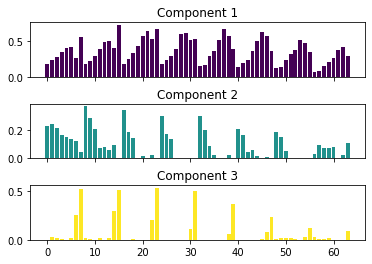

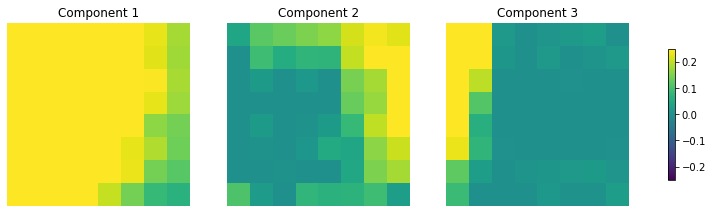

In [120]:
for components in pca_components:
    print(components.shape)
    analysis.plot_features_bar(components[:3])
    analysis.plot_features_grid(components[:3],vmin=-0.25,vmax=0.25)

## NMF on individual fingers

In [127]:
nmf = NMF(n_components=2, init='random', random_state=42)
nmf_components = []
for array in individual_finger_data:
    # model takes (samples, features)
    nmf.fit(array.T)
    nmf_components.append(nmf.components_)

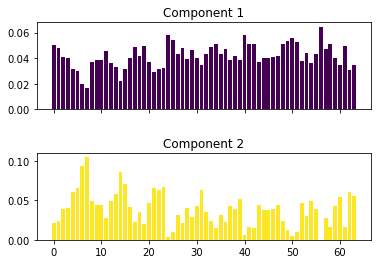

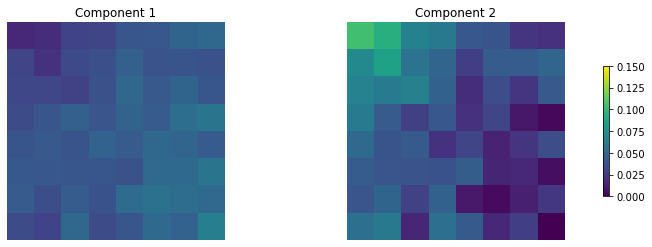

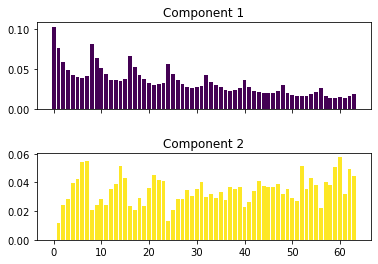

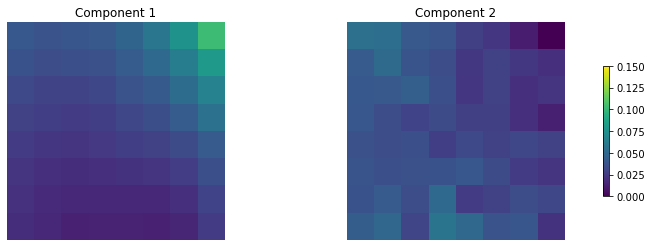

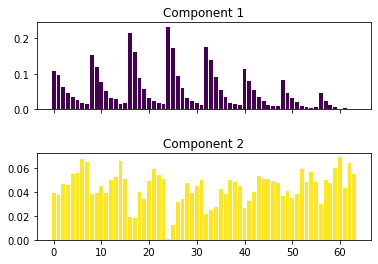

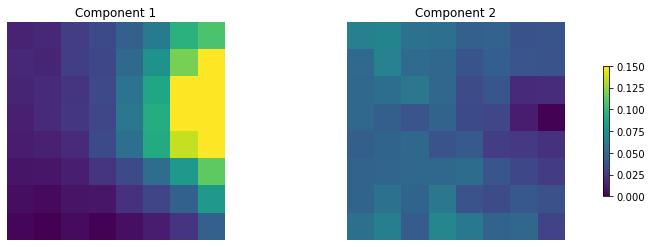

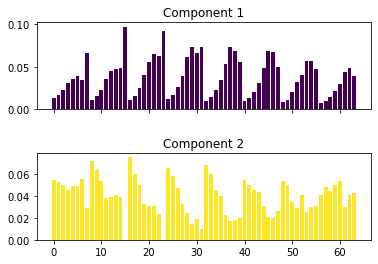

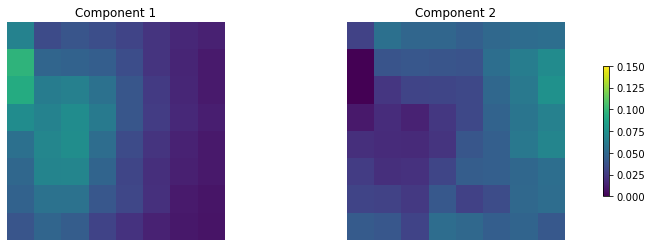

In [129]:
for components in nmf_components:
    analysis.plot_features_bar(components)
    analysis.plot_features_grid(components,vmin=0,vmax=0.15)

In [ ]:
# create stacks from event indices
event_stack = [[]]
for i, peak_idx in enumerate(peak_indices):
    event_stack[0].append(processed_emg[:,(peak_idx-width//2):(peak_idx+width//2)])
f = analysis.plot_stacked_events(event_stack)
f = analysis.plot_events(event_stack[0][:10])

## dPCA on finger stacks